In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.optimize import Bounds

# some stuff for nice plots
font = {'size': 16}
matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = [10, 8]

# (a)
## Create training data set

In [2]:
m = 1000

x = np.zeros((1, m))
x[0, :] = -1.0 + 2.0 * np.random.rand(m)

y = np.ones((1, m))
# y[0, np.where(np.absolute(x[0, :]) <= 0.5)] = -1.0
y[0, np.where(x[0, :] <= 0.5)] = -1.0

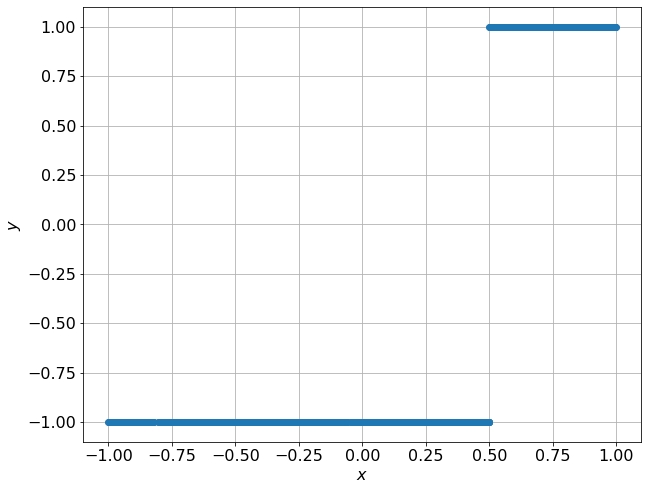

In [3]:
ii = np.argsort(x[0, :])

plt.plot(x[0, ii], y[0, ii], 'o')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()
plt.show()

# Neural net, loss function and gradient

In [4]:
def fparts(x, w_):
    x1 = np.tanh(w_[0] * x + w_[3])
    x2 = np.tanh(w_[1] * x1 + w_[4])
    y = np.tanh(w_[2] * x2)
    return x1, x2, y

def f(x, w_):
    x1, x2, y = fparts(x, w_)
    return y

def Ehat(x, y, w_):
    return 0.5 * np.power(y - f(x, w_), 2)

def nablaEhat(x, y0, w_):
    x1, x2, y = fparts(x, w_)
    
    dEdy = -(y0 - y)
    
    c0 = 1.0 - np.power(x1, 2)
    c1 = 1.0 - np.power(x2, 2)
    c2 = 1.0 - np.power(y, 2)
    
    dE = np.zeros((5, x.shape[1]))
    dE[2, :] = dEdy * c2 * x2
    dE[1, :] = dEdy * (c2 * w_[2]) * c1 * x1
    dE[4, :] = dEdy * (c2 * w_[2]) * c1
    dE[0, :] = dEdy * (c2 * w_[2]) * (c1 * w_[1]) * c0 * x
    dE[3, :] = dEdy * (c2 * w_[2]) * (c1 * w_[1]) * c0
    
    return dE

def E(X, Y, w_):
    return np.sum(Ehat(X, Y, w_), axis=1) / float(m)

def nablaE(X, Y, w_):
    return np.sum(nablaEhat(X, Y, w_), axis=1) / float(m)
    
def classify(x):
    y = -1.0 * np.ones(x.shape)
    y[0, np.where(x[0, :] > 0)] = 1.0
    return y

# Solve training problem with fixed learning rate

In [5]:
nHoldout = 200
bestScore = 1e10

# loop over 10 test runs
for i in range(10):
    iTrain = np.random.permutation(np.arange(m))
    xTrain = x[:, iTrain[:-nHoldout]]
    yTrain = y[:, iTrain[:-nHoldout]]
    
    w = -10.0 + 20.0 * np.random.rand(5)
    v = -nablaE(x, y, w)
    eta_0 = 0.1
    
    s = 0
    while np.linalg.norm(v, 2) > 1e-6 and s < 1000:

        # optimize step length given w and v
        res = minimize(lambda eta_: E(xTrain, yTrain, w + eta_ * v), eta_0, method='SLSQP')
        eta = res.x[0]

        # update w and calculate new objective function value and gradient
        w += eta * v
        v = -nablaE(xTrain, yTrain, w)
        
        # update initial guess
        eta_0 = eta
        
        s += 1

    print('Run {} Done after {} iterations'.format(i, s))
    
    # evaluate the number of misclassifications on the test set 
    xTest = x[:, iTrain[-nHoldout:]]
    yTest = y[:, iTrain[-nHoldout:]]
    
    score = 0.5 * np.sum(np.abs(yTest - classify(f(xTest, w))))
    if score < bestScore:
        print('-> score improved: {}, w = ({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(score, w[0], w[1], w[2], w[3], w[4]))
        bestScore = score
        bestw = w
    else:
        print('-> score: {}, w = ({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(score, w[0], w[1], w[2], w[3], w[4]))
        
print('Done. Best Score: {}, w = ({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(bestScore, bestw[0], bestw[1], bestw[2], bestw[3], bestw[4]))

Run 0 Done after 1000 iterations
-> score improved: 0.0, w = (-7.35, 7.50, -3.24, 2.89, 4.95)
Run 1 Done after 0 iterations
-> score: 148.0, w = (-2.77, 4.93, -8.35, -4.93, 2.42)
Run 2 Done after 1000 iterations
-> score: 41.0, w = (8.50, 4.74, -5.15, -0.69, 8.02)
Run 3 Done after 1000 iterations
-> score: 50.0, w = (-4.20, 2.48, 0.60, -4.92, -2.76)
Run 4 Done after 1000 iterations
-> score: 153.0, w = (-6.76, 4.61, 7.94, -7.30, 6.72)
Run 5 Done after 1000 iterations
-> score: 49.0, w = (1.22, 1.33, -3.91, 9.33, 7.56)
Run 6 Done after 1000 iterations
-> score: 156.0, w = (-2.10, -1.77, 3.55, -9.61, 2.31)
Run 7 Done after 1000 iterations
-> score: 148.0, w = (5.34, -9.50, 6.73, -8.57, -5.54)
Run 8 Done after 1000 iterations
-> score: 47.0, w = (-9.73, -5.17, 0.59, 8.46, -9.73)
Run 9 Done after 1000 iterations
-> score: 1.0, w = (-4.10, -9.13, 2.77, 1.43, -5.09)
Done. Best Score: 0.0, w = (-7.35, 7.50, -3.24, 2.89, 4.95)


## Minimization using a SciPy optimizer

In [6]:
res = minimize(lambda b: E(x, y, b), bestw, method='BFGS', jac=lambda b: nablaE(x, y, b))
w2 = res.x
print(w2)

[-12.73027431  22.34708627 -20.51126672   6.73578636  -7.98640389]


## Plot

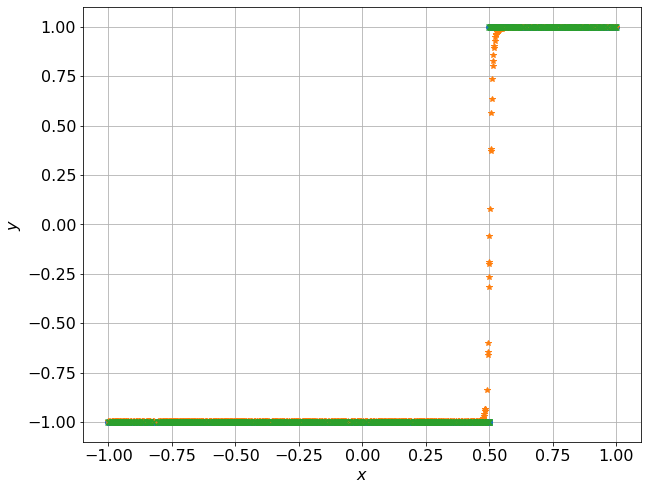

In [7]:
plt.plot(x[0, :], y[0, :], 'o')
plt.plot(x[0, :], f(x, bestw)[0, :], '*')
plt.plot(x[0, :], f(x, w2)[0, :], 'x')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()
plt.show()

# b)

In [8]:
m = 1000
x = -3.0 + 6.0 * np.random.rand(2, m)

y = np.zeros((1, m))
for i in range(m):
    if x[1, i] > 0.2 * np.power(x[0, i], 3) - 0.8 * x[0, i]:
        y[0, i] = 1.0
    else:
        y[0, i] = -1.0

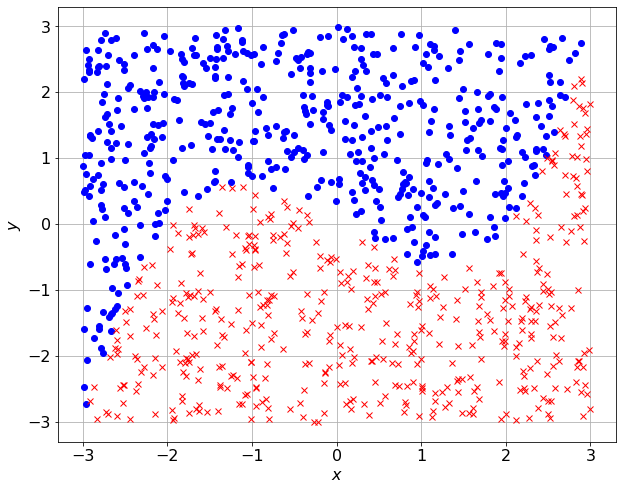

In [9]:
plt.plot(x[0, np.where(y[0,:] > 0)], x[1, np.where(y[0,:] > 0)], 'bo')
plt.plot(x[0, np.where(y[0,:] < 0)], x[1, np.where(y[0,:] < 0)], 'rx')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()
plt.show()

# Neural net, loss function and gradient

In [10]:
def fparts(x, w_):
    x1 = np.array([np.tanh(w_[0] * x[0, :] + w_[1] * x[1, :]), 
                   np.tanh(w_[2] * x[0, :] + w_[3] * x[1, :]), 
                   np.tanh(w_[4] * x[0, :] + w_[5] * x[1, :])]
                 )
    y = np.tanh(w_[6] * x1[0, :] + w_[7] * x1[1, :] + w_[8] * x1[2, :])
    return x1, y

def f(x, w_):
    x1, y = fparts(x, w_)
    return y

def Ehat(x, y, w_):
    return 0.5 * np.power(y - f(x, w_), 2)

def nablaEhat(x, y0, w_):
    x1, y = fparts(x, w_)
    
    dEdy = -(y0 - y)
    
    c0 = 1.0 - np.power(y, 2)
    c1 = 1.0 - np.power(x1, 2)
    
    dE = np.zeros((9, x.shape[1]))
    dE[0, :] = w_[6] * c1[0, :] * x[0, :]
    dE[1, :] = w_[6] * c1[0, :] * x[1, :]
    dE[2, :] = w_[7] * c1[1, :] * x[0, :]
    dE[3, :] = w_[7] * c1[1, :] * x[1, :]
    dE[4, :] = w_[8] * c1[2, :] * x[0, :]
    dE[5, :] = w_[8] * c1[2, :] * x[1, :]
    dE[6, :] = x1[0, :]
    dE[7, :] = x1[1, :]
    dE[8, :] = x1[2, :]
    
    dE *= dEdy * c0
    
    return dE

def E(X, Y, w_):
    return np.sum(Ehat(X, Y, w_), axis=1) / float(m)

def nablaE(X, Y, w_):
    return np.sum(nablaEhat(X, Y, w_), axis=1) / float(m)
    
def classify(x):
    y = -1.0 * np.ones(x.shape)
    y[np.where(x > 0)] = 1.0
    return y

# Solve training problem with fixed learning rate

In [15]:
nHoldout = int(m / 5)

bestScore = 1e10

# loop over 10 test runs
for i in range(10):

    iTrain = np.random.permutation(np.arange(m))
    xTrain = x[:, iTrain[:-nHoldout]]
    yTrain = y[:, iTrain[:-nHoldout]]
    
    w = -50.0 + 100.0 * np.random.rand(9)
    v = -nablaE(x, y, w)
    Ej = E(xTrain, yTrain, w)
    
    eta_0 = 5.0
    
    s = 0
    while np.linalg.norm(v, 2) > 1e-6 and s < 1000:

        # optimize step length given w and v
        res = minimize(lambda eta_: E(xTrain, yTrain, w + eta_ * v), eta_0, method='trust-constr')
        eta = res.x[0]

        # update w and calculate new objective function value and gradient
        w += eta * v
        v = -nablaE(xTrain, yTrain, w)
        Ej = E(xTrain, yTrain, w)
        
        # update initial guess
        eta_0 = eta
        
        s += 1

    print('Run {} Done after {} iterations'.format(i, s))
    
    # evaluate the number of misclassifications on the test set 
    xTest = x[:, iTrain[-nHoldout:]]
    yTest = y[0, iTrain[-nHoldout:]]
    
    score = 0.5 * np.sum(np.abs(yTest - classify(f(xTest, w))))
    if score < bestScore:
        print('-> score improved: {}, w = ({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(score, w[0], w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8]))
        bestScore = score
        bestw = w
    else:
        print('-> score: {}, w = ({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(score, w[0], w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8]))

w = bestw
score = bestScore
print('Done. Best Score: {}, w = ({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(score, w[0], w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8]))

Run 0 Done after 0 iterations
-> score improved: 48.0, w = (-28.96, 30.18, 14.22, 20.45, -16.37, -17.66, -1.94, 41.63, -13.12)


C:\Users\sebas\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Run 1 Done after 103 iterations
-> score improved: 33.0, w = (18.60, 42.64, 14.54, -43.76, -1.03, 14.35, -37.77, -27.85, 21.78)
Run 2 Done after 1 iterations
-> score: 95.0, w = (-20.59, 17.12, 45.76, 11.66, 46.70, -42.69, -30.21, 25.47, -10.62)
Run 3 Done after 1 iterations
-> score: 57.0, w = (-42.99, 32.57, 43.41, 14.39, -15.06, 11.55, 31.77, 3.15, 24.22)
Run 4 Done after 1 iterations
-> score: 111.0, w = (-27.62, 11.40, -21.74, -2.25, 41.38, 18.35, -20.22, -38.32, 36.18)
Run 5 Done after 1000 iterations
-> score improved: 31.0, w = (-10.22, 15.30, 44.23, -19.87, -34.54, -15.71, 39.70, 13.38, -25.70)
Run 6 Done after 48 iterations
-> score: 106.0, w = (28.54, 2.80, 27.55, 26.56, -24.82, -2.64, 26.68, 11.37, -23.69)
Run 7 Done after 4 iterations
-> score improved: 26.0, w = (21.53, 9.77, 36.00, 15.93, -19.82, 45.13, -23.00, 34.28, 29.46)
Run 8 Done after 1 iterations
-> score: 126.0, w = (-36.32, 6.37, -6.01, 30.31, -23.43, 37.28, -46.93, -6.04, -10.16)
Run 9 Done after 0 iterations


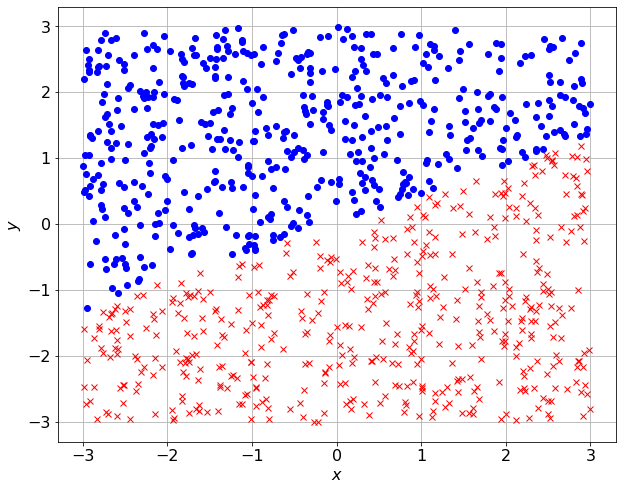

In [16]:
yNN = classify(f(x, w))

plt.plot(x[0, np.where(yNN > 0)], x[1, np.where(yNN > 0)], 'bo')
plt.plot(x[0, np.where(yNN < 0)], x[1, np.where(yNN < 0)], 'rx')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()
plt.show()

## Minimization using a SciPy optimizer

In [13]:
bestScore2 = 1e10
for i in range(100):
    
    iTrain = np.random.permutation(np.arange(m))
    xTrain = x[:, iTrain[:-nHoldout]]
    yTrain = y[:, iTrain[:-nHoldout]]
    
    w0 = -50.0 + 100.0 * np.random.rand(9)
    res = minimize(lambda b: E(xTrain, yTrain, b), w0, method='BFGS', jac=lambda b: nablaE(xTrain, yTrain, b))
    w2 = res.x
    
    # evaluate the number of misclassifications on the test set 
    xTest = x[:, iTrain[-nHoldout:]]
    yTest = y[0, iTrain[-nHoldout:]]
    
    score2 = 0.5 * np.sum(np.abs(yTest - classify(f(xTest, w2))))
    
    if score2 < bestScore2:
        bestScore2 = score2
        bestw2 = w2
        print(i, bestScore2)

score2 = bestScore2
w2 = bestw2

print(w2)

0 53.0
1 19.0
24 18.0
25 4.0
40 2.0
52 1.0
67 0.0
[-5.14155727e-01 -7.56270999e-02 -2.05075176e+03 -1.74022287e+03
  2.49908018e-01 -3.90311225e-02 -3.92717473e+03 -7.58500305e+01
 -6.73431464e+03]


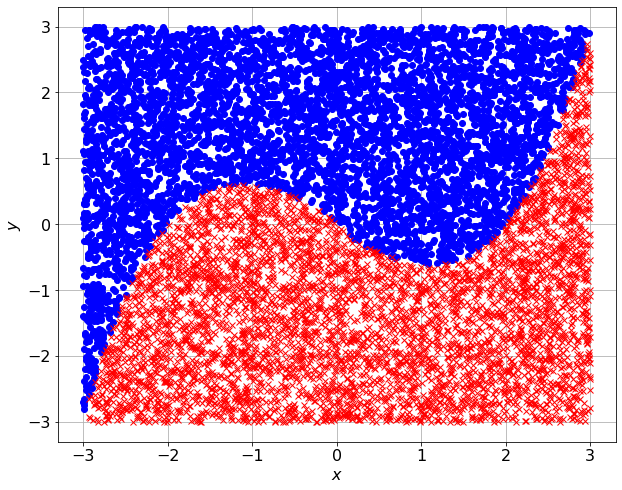

In [14]:
xLarge = -3.0 + 6.0 * np.random.rand(2, 10000)

yNN = classify(f(xLarge, w2))

plt.plot(xLarge[0, np.where(yNN > 0)], xLarge[1, np.where(yNN > 0)], 'bo')
plt.plot(xLarge[0, np.where(yNN < 0)], xLarge[1, np.where(yNN < 0)], 'rx')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()
plt.show()